In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, precision_score, f1_score, recall_score)
from scipy.spatial.distance import euclidean
from joblib import Parallel, delayed
from IPython.display import clear_output

# Custom modules
import Functions.dataFrameTools as dataFrameTools
import Functions.processGen as processGen

# Model import
from parametricVAE import dVAE

import SVMClassifier
import latentKDEClassifier
import pickle
import joblib
# Reload after changes
from importlib import reload
reload(SVMClassifier)
reload(latentKDEClassifier)

# Access the class
from SVMClassifier import SVMClassifier
from latentKDEClassifier import LatentKDEClassifier


### Fetch all datasets

In [2]:
###### Fetch all ratings across all groups ######
rated_bikes_df = pd.read_csv('ratings/combined_clean_ratings.csv')


###### Import BIKED visually reduced dataset ######

dfn = dataFrameTools.normalizeDF(0).astype('float32')
visual_df =pd.read_csv("../data/clip_sBIKED_reduced.csv", index_col=0)
columns_to_drop = [col for col in visual_df.columns if 'color' in col]
visual_df.drop(columns=columns_to_drop, inplace=True)
boolean_columns = visual_df.select_dtypes(include=['bool']).columns
visual_df[boolean_columns] = visual_df[boolean_columns].astype(int)
visual_df = visual_df.sort_index(axis=1)
visual_df = visual_df.select_dtypes(include=['number'])
constant_columns = [col for col in visual_df.columns if visual_df[col].nunique() == 1]
visual_df = visual_df.drop(columns=constant_columns)



###### Split rated bikes to usable/unusable ######

threshold_usable = 0.7
threshold_unusable = 1- threshold_usable

average_ratings = rated_bikes_df.groupby('bid')['rating'].mean()
usable_bikes = visual_df.loc[average_ratings[average_ratings >= threshold_usable].index]
unusable_bikes = visual_df.loc[average_ratings[average_ratings <= threshold_unusable].index]
meaningfull_bikes_df = pd.concat([usable_bikes, unusable_bikes])
meaningfull_bikes_df['usable'] = meaningfull_bikes_df.index.isin(usable_bikes.index).astype(int)

usable_ids = meaningfull_bikes_df[meaningfull_bikes_df['usable'] == True].index.tolist()
unusable_ids = meaningfull_bikes_df[meaningfull_bikes_df['usable'] == False].index.tolist()

usable_bikes = dfn.loc[usable_ids] 
unusable_bikes = dfn.loc[unusable_ids] 



##### Import Train and Test Sets ######

input_folder = 'datasets'

X_test = pd.read_csv(os.path.join(input_folder,'X_test.csv'), index_col=0)
y_test = pd.read_csv(os.path.join(input_folder,'y_test.csv'), index_col=0)
X_train = pd.read_csv(os.path.join(input_folder,'X_train.csv'), index_col=0)
y_train = pd.read_csv(os.path.join(input_folder,'y_train.csv'), index_col=0)

X_test_dfn = dfn.loc[X_test.index]
X_train_dfn = dfn.loc[X_train.index]

usable_bikes_train_df = X_train[y_train['usable'] == 1]
unusable_bikes_train_df = X_train[y_train['usable'] == 0]

usable_bikes_test_df = X_test[y_test['usable'] == 1]
unusable_bikes_test_df = X_test[y_test['usable'] == 0]

usable_bikes_test_dfn = dfn.loc[usable_bikes_test_df.index]
usable_bikes_train_dfn = dfn.loc[usable_bikes_train_df.index]
unusable_bikes_test_dfn = dfn.loc[unusable_bikes_test_df.index]
unusable_bikes_train_dfn = dfn.loc[unusable_bikes_train_df.index]


Loaded Imputed Dataframe in  1.718000888824463 seconds


In [15]:
dfn.shape

(4512, 2395)

### Build VAE and get latent representations of usable/unusable bikes


In [3]:
ddims = 2395
tuned_VAE_name = 'augmented_VAE'

dataVAE_model =dVAE(ddims, 128, 0.1, 1e-3)
dataVAE_mean = dataVAE_model.build_vae_keras_model_mean()
dataVAE_mean.load_weights('model weights/dataVAE.h5')
encoder_mean =  dataVAE_mean.get_layer('encoder')
decoder_mean =  dataVAE_mean.get_layer('decoder')

tunedVAE=dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
tunedVAE.load_weights(f'model weights/{tuned_VAE_name}.h5')
tuned_decoder =  tunedVAE.get_layer('decoder')
tuned_encoder_mean =  tunedVAE.get_layer('encoder')

usable_bikes = dfn.loc[usable_ids] 
unusable_bikes = dfn.loc[unusable_ids] 
encoder = tuned_encoder_mean
decoder = tuned_decoder

latent_usable = encoder.predict(usable_bikes)
latent_unusable = encoder.predict(unusable_bikes)

latent_usable_test = encoder.predict(usable_bikes_test_dfn)
latent_usable_train = encoder.predict(usable_bikes_train_dfn)
latent_unusable_test = encoder.predict(unusable_bikes_test_dfn)
latent_unusable_train = encoder.predict(unusable_bikes_train_dfn)
clear_output(wait=False)

### Fit KDEs


In [4]:
def calculate_log_likelihoods_with_cross_validation(bandwidths_usable, bandwidths_unusable, 
                                                    latent_usable_train, latent_unusable_train, 
                                                    n_splits=10):
    
    def calculate_log_odds(dataset, kde):
        log_odds = []
        for point in dataset:
            point = np.reshape(point, (1, -1))  # Ensure correct shape
            log_likelihood = kde.score_samples(point)
            log_odds.append(log_likelihood)
        return log_odds

    best_bandwidth_usable = None
    best_bandwidth_unusable = None
    best_accuracy = -np.inf
    best_preds = []
    best_y_preds = []
    for bw_usable in bandwidths_usable:
        for bw_unusable in bandwidths_unusable:

            accuracies = []
            # Define cross-validation strategy
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

            all_preds = []
            all_y_val = []

            # Cross-validation loop
            for (train_usable_idx, val_usable_idx), (train_unusable_idx, val_unusable_idx) in zip(kf.split(latent_usable_train), kf.split(latent_unusable_train)):
                # Fit the KDE models on the training data
                kde_usable = KernelDensity(kernel='gaussian', bandwidth=bw_usable)
                kde_usable.fit(latent_usable_train[train_usable_idx])
                
                kde_unusable = KernelDensity(kernel='gaussian', bandwidth=bw_unusable)
                kde_unusable.fit(latent_unusable_train[train_unusable_idx])

                # Concatenate the validation set (usable + unusable)
                val_set = np.concatenate([latent_usable_train[val_usable_idx], latent_unusable_train[val_unusable_idx]])

                # Create the corresponding labels for the validation set (1 for usable, 0 for unusable)
                y_val = np.concatenate([np.ones(len(val_usable_idx)), np.zeros(len(val_unusable_idx))])

                # Calculate log-odds for both KDEs on the validation set
                log_odds_usable = calculate_log_odds(val_set, kde_usable)
                log_odds_unusable = calculate_log_odds(val_set, kde_unusable)

                # Generate predictions based on log-odds comparison
                preds = [1 if log_odds_usable[i] > log_odds_unusable[i] else 0 
                            for i in range(len(log_odds_usable))]

                # Calculate accuracy of this fold
                accuracy = accuracy_score(y_val, preds)  # Compare predictions with true labels
                # accuracy = f1_score(y_val, preds)
                accuracies.append(accuracy)

                # Append the predictions and true labels for confusion matrix
                all_preds.extend(preds)
                all_y_val.extend(y_val)


            # Return the mean accuracy for this combination of bandwidths
            mean_accuracy =  np.mean(accuracies)

            if mean_accuracy > best_accuracy:
                best_accuracy = mean_accuracy
                best_bandwidth_usable = bw_usable
                best_bandwidth_unusable = bw_unusable
                best_preds = all_preds
                best_y_preds = all_y_val

    cm = confusion_matrix(best_y_preds, best_preds)
    # print(cm)
    ConfusionMatrixDisplay(cm, display_labels=["Unusable", "Usable"]).plot()
    report = classification_report(best_y_preds, best_preds, target_names=["Unusable", "Usable"])
    print(report)
    return best_bandwidth_usable, best_bandwidth_unusable, best_accuracy



              precision    recall  f1-score   support

    Unusable       0.62      0.78      0.69        41
      Usable       0.68      0.49      0.57        39

    accuracy                           0.64        80
   macro avg       0.65      0.63      0.63        80
weighted avg       0.65      0.64      0.63        80

Best bandwidth for usable KDE: 0.31
Best bandwidth for unusable KDE: 0.28
Best accuracy: 0.6371078431372549


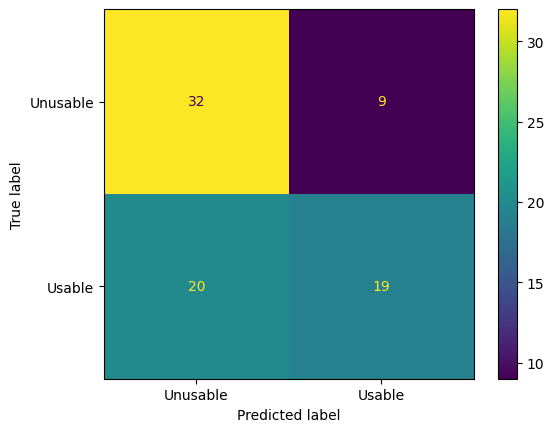

In [5]:
# Define the range of bandwidths to test for both KDEs
bandwidths_usable = [i*0.01 + 0.2 for i in range(20)]   # Bandwidths for usable KDE  0.2 - 0.4 with step 0.01
bandwidths_unusable = [i*0.01 + 0.2 for i in range(20)]  # Bandwidths for unusable KDE 0.2 - 0.4 with step 0.01

# Calculate the best bandwidths
best_bandwidth_usable, best_bandwidth_unusable, best_accuracy = calculate_log_likelihoods_with_cross_validation(
    bandwidths_usable,
    bandwidths_unusable,
    latent_usable_train,
    latent_unusable_train,
    n_splits=5
)

print("Best bandwidth for usable KDE:", best_bandwidth_usable)
print("Best bandwidth for unusable KDE:", best_bandwidth_unusable)
print("Best accuracy:", best_accuracy)

latent_kde_classifier = LatentKDEClassifier(best_bandwidth_usable, best_bandwidth_unusable)
latent_kde_classifier.fit(latent_usable_train, latent_unusable_train)



In [ ]:
# # Load filtered KDE classifier
# with open("model weights/latent_kde_classifier.pkl", "rb") as f:
#     data = pickle.load(f)

# latent_kde_classifier = LatentKDEClassifier(data["bandwidth_usable"], data["bandwidth_unusable"])
# latent_kde_classifier.fit(data["latent_usable_train"], data["latent_unusable_train"])

## Building SVM Classifier


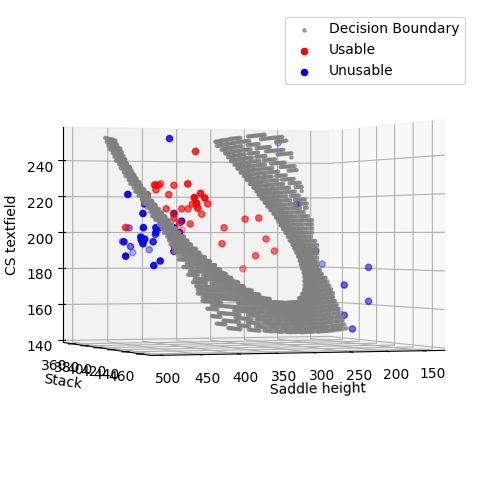

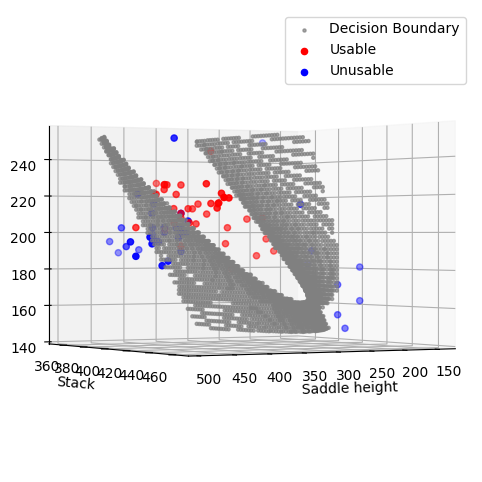

0.9


In [5]:
features = ['Saddle height', 'Stack', 'CS textfield']
# columns_to_keep =['CS textfield', 'Saddle height']
column_indices_to_keep = [unusable_bikes_train_dfn.columns.get_loc(col) for col in features]

X_feature = X_train_dfn[features].values  
y_train_series = y_train['usable']
# svm_clf = SVMClassifier(kernel='rbf', degree=2, C= 50, scaler=1000)
svm_clf = SVMClassifier(kernel='poly',C = 600, coef0 = 10, degree= 2, gamma='scale', scaler=1000)
svm_clf.fit(X_feature, y_train_series)  

svm_clf.plot_hyperplane_with_points(X_feature, y_train_series,features,elev=0, azim=70 )
svm_clf.plot_hyperplane_with_points(X_feature, y_train_series,features,elev=0, azim=60 )

y_pred = svm_clf.predict(X_feature)
print(accuracy_score(y_train_series, y_pred))

# joblib.dump(svm_clf, "scaled_svm_classifier.pkl")


# svm_clf = joblib.load("model weights/scaled_svm_classifier.pkl")


In [9]:
## Test accuracy
X_feature = X_test_dfn[features].values  
y_train_series = y_test['usable']
y_pred = svm_clf.predict(X_feature)
print(accuracy_score(y_train_series, y_pred))

0.95


### Filter poorly represented designs 


33
28
              precision    recall  f1-score   support

    Unusable       0.77      0.82      0.79        28
      Usable       0.84      0.79      0.81        33

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.81      0.80      0.80        61

Best bandwidth for usable KDE: 0.28
Best bandwidth for unusable KDE: 0.25
Best accuracy: 0.806993006993007


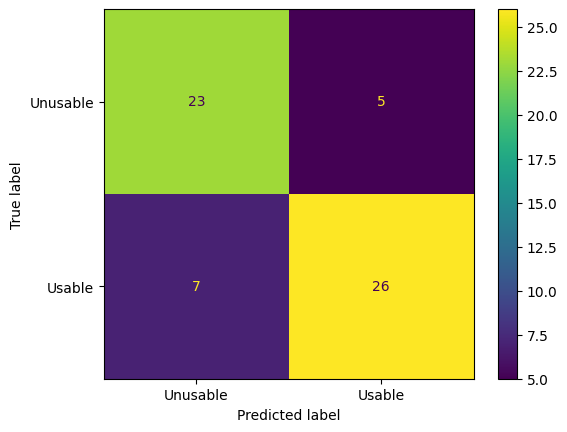

In [6]:
latent_kde_classifier = None
features = ['Saddle height', 'Stack', 'CS textfield']
column_indices_to_keep = [unusable_bikes_train_dfn.columns.get_loc(col) for col in features]

latent_unusable_train_filtered = np.empty((0, latent_usable_train.shape[1]))
unusable_bids = []

for bid in unusable_bikes_train_df.index:
    bike = unusable_bikes.loc[[bid]]
    latent = tuned_encoder_mean.predict(bike)[0]
    bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
    pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]

    if pred_svm == 0:
        latent_unusable_train_filtered = np.append(latent_unusable_train_filtered, [latent], axis=0)
        unusable_bids.append(bid)


latent_usable_train_filtered = np.empty((0, latent_usable_train.shape[1]))
usable_bids = []
for bid in usable_bikes_train_df.index:
    bike = usable_bikes.loc[[bid]]
    latent = tuned_encoder_mean.predict(bike)[0]
    bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
    pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]

    if pred_svm == 1:
        latent_usable_train_filtered = np.append(latent_usable_train_filtered, [latent], axis=0)
        usable_bids.append(bid)


clear_output(False)


print(len(latent_usable_train_filtered))
print(len(latent_unusable_train_filtered))


usable_bikes_train_filtered_dfn = usable_bikes_train_dfn.loc[usable_bids]
unusable_bikes_train_filtered_dfn = unusable_bikes_train_dfn.loc[unusable_bids]

# Define the range of bandwidths to test for both KDEs
bandwidths_usable = [i*0.01 + 0.2 for i in range(30)]   # Bandwidths for usable KDE  0.2 - 0.5 with step 0.01
bandwidths_unusable = [i*0.01 + 0.2 for i in range(30)]  # Bandwidths for unusable KDE 0.2 - 0.5 with step 0.01

# Calculate the best bandwidths
best_bandwidth_usable, best_bandwidth_unusable, best_accuracy = calculate_log_likelihoods_with_cross_validation(
    bandwidths_usable,
    bandwidths_unusable,
    latent_usable_train_filtered,
    latent_unusable_train_filtered,
    n_splits=5
)

print("Best bandwidth for usable KDE:", best_bandwidth_usable)
print("Best bandwidth for unusable KDE:", best_bandwidth_unusable)
print("Best accuracy:", best_accuracy)

latent_kde_classifier = LatentKDEClassifier(best_bandwidth_usable, best_bandwidth_unusable)
latent_kde_classifier.fit(latent_usable_train_filtered, latent_unusable_train_filtered)


# # Save the classifier's essential data
# with open("latent_kde_classifier.pkl", "wb") as f:
#     pickle.dump({
#         "bandwidth_usable": best_bandwidth_usable,
#         "bandwidth_unusable": best_bandwidth_unusable,
#         "latent_usable_train": latent_usable_train_filtered,
#         "latent_unusable_train": latent_unusable_train_filtered
#     }, f)


### Test


0.75
              precision    recall  f1-score   support

    Unusable       0.73      0.80      0.76        10
      Usable       0.78      0.70      0.74        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20



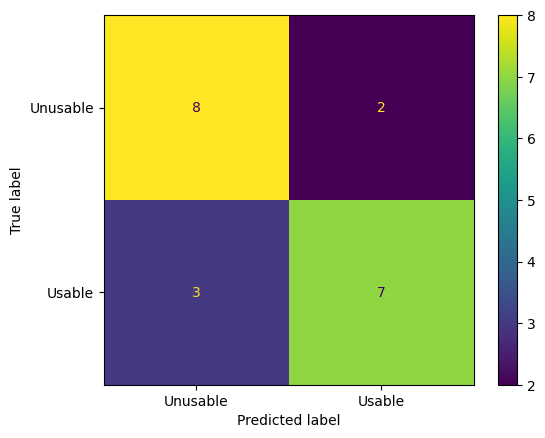

In [16]:
X_to_test = np.concatenate([latent_usable_test, latent_unusable_test])
y_to_test = np.concatenate([np.ones(len(latent_usable_test)), np.zeros(len(latent_unusable_test))])
preds =latent_kde_classifier.predict(X_to_test)
print(accuracy_score(y_to_test, preds))
cm = confusion_matrix(y_to_test, preds)
# print(cm)
ConfusionMatrixDisplay(cm, display_labels=["Unusable", "Usable"]).plot()
report = classification_report(y_to_test, preds, target_names=["Unusable", "Usable"])
print(report)

### Finding best direction

In [23]:
def initialize_models():
    # best_bandwidth_usable =  0.28
    # best_bandwidth_unusable=  0.25
    
    # Initialize and return fresh instances of the models
    # latent_kde_classifier_temp = LatentKDEClassifier(
    #     best_bandwidth_usable,
    #     best_bandwidth_unusable,
    #     min_confidence_usable=None
    # )
    # latent_kde_classifier_temp.fit(latent_usable_train_filtered, latent_unusable_train_filtered)

    latent_kde_classifier_temp = LatentKDEClassifier(best_bandwidth_usable, best_bandwidth_unusable)
    latent_kde_classifier_temp.fit(latent_usable_train_filtered, latent_unusable_train_filtered)

    tunedVAE = dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
    tunedVAE.load_weights(f'model weights/{tuned_VAE_name}.h5')
    tuned_encoder_mean = tunedVAE.get_layer('encoder')

    return latent_kde_classifier, tuned_encoder_mean

def process_pair(dir, alpha):
    try:
        # Initialize models locally to avoid pickle issues
        latent_kde_classifier_temp, tuned_encoder_mean = initialize_models()


        bikes = unusable_bikes_train_df.index
        pair_results = []
        avg_count = 0
        valid_count = 0

        for bid in bikes:
            bike = unusable_bikes.loc[[bid]]
            latent = tuned_encoder_mean.predict(bike)[0]  # Get the latent vector
            points = [latent]
            pred_kde = latent_kde_classifier_temp.predict(latent)[0]
            counter = 0

            while counter < 100 and pred_kde == 0:
                counter += 1
                new_point = latent_kde_classifier_temp.move_point(latent, step_scale=0.1, use_direction=dir, alpha=alpha)
                points.append(new_point)
                latent = new_point
                pred_kde = latent_kde_classifier_temp.predict(latent)[0]

            if pred_kde and counter > 0:
                avg_count += counter
                valid_count += 1

        pair_results.append({
            'dir': dir,
            'alpha': alpha,
            'avg_count': avg_count / valid_count if valid_count != 0 else np.inf,
            'valid_count': valid_count
        })

        return pair_results

    except Exception as e:
        print(f"Error processing pair (dir={dir}, alpha={alpha}): {e}")
        return [f"Error processing pair (dir={dir}, alpha={alpha}): {e}"]


# Main process
if __name__ == '__main__':
    directions = [i for i in range(1,5)]

    alphas = [0.1,0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9]
    pairs = [(direction, alpha if direction == 4 else None) for direction in directions for alpha in (alphas if direction == 4 else [None])]

    # Parallel execution with separate model initialization for each worker
    results = Parallel(n_jobs=-1)(
        delayed(process_pair)(dir, alpha) for dir, alpha in pairs
    )

    clear_output(False)
    print(results)


[[{'dir': 1, 'alpha': None, 'avg_count': 17.483870967741936, 'valid_count': 31}], [{'dir': 2, 'alpha': None, 'avg_count': 45.45161290322581, 'valid_count': 31}], [{'dir': 3, 'alpha': None, 'avg_count': 17.322580645161292, 'valid_count': 31}], [{'dir': 4, 'alpha': 0.1, 'avg_count': 29.64516129032258, 'valid_count': 31}], [{'dir': 4, 'alpha': 0.2, 'avg_count': 22.322580645161292, 'valid_count': 31}], [{'dir': 4, 'alpha': 0.3, 'avg_count': 18.741935483870968, 'valid_count': 31}], [{'dir': 4, 'alpha': 0.4, 'avg_count': 17.774193548387096, 'valid_count': 31}], [{'dir': 4, 'alpha': 0.5, 'avg_count': 17.322580645161292, 'valid_count': 31}], [{'dir': 4, 'alpha': 0.6, 'avg_count': 17.032258064516128, 'valid_count': 31}], [{'dir': 4, 'alpha': 0.7, 'avg_count': 17.096774193548388, 'valid_count': 31}], [{'dir': 4, 'alpha': 0.8, 'avg_count': 17.193548387096776, 'valid_count': 31}], [{'dir': 4, 'alpha': 0.9, 'avg_count': 17.35483870967742, 'valid_count': 31}]]


In [25]:
results_df = pd.DataFrame(results)
results_df

,0
0,"{'dir': 1, 'alpha': None, 'avg_count': 17.4838..."
1,"{'dir': 2, 'alpha': None, 'avg_count': 45.4516..."
2,"{'dir': 3, 'alpha': None, 'avg_count': 17.3225..."
3,"{'dir': 4, 'alpha': 0.1, 'avg_count': 29.64516..."
4,"{'dir': 4, 'alpha': 0.2, 'avg_count': 22.32258..."
5,"{'dir': 4, 'alpha': 0.3, 'avg_count': 18.74193..."
6,"{'dir': 4, 'alpha': 0.4, 'avg_count': 17.77419..."
7,"{'dir': 4, 'alpha': 0.5, 'avg_count': 17.32258..."
8,"{'dir': 4, 'alpha': 0.6, 'avg_count': 17.03225..."
9,"{'dir': 4, 'alpha': 0.7, 'avg_count': 17.09677..."


## Impact of Movements on SVM Decision Boundary Distance

### Train set

Number of bikes moved : 28


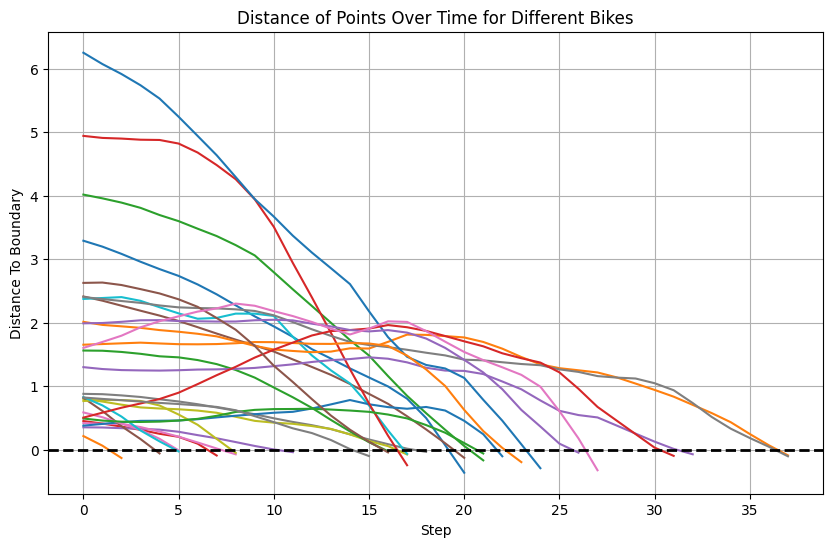

In [7]:
# latent_kde_classifier, tuned_encoder_mean = initialize_models()

bikes = unusable_bikes_train_df.index

log_usable_scores = []
log_unusable_scores = []

knn_pred = []

all_points = []

for bid in bikes:
    bike = unusable_bikes.loc[[bid]]
    latent = tuned_encoder_mean.predict(bike)[0]
    points = [latent]
    pred_svm = pred_kde = 0
    counter = 0

    bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
    pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
    pred_kde = latent_kde_classifier.predict(latent)[0]

    distances = []

    distances.append(- svm_clf.distance_to_boundary(bike_features_point))

    print('svm:', 'usable' if pred_svm else 'unusable')
    print('kde:', 'usable' if pred_kde else 'unusable')
    while counter < 40 and not (pred_svm == 1):

        counter += 1

        new_point = latent_kde_classifier.move_point(latent,step_scale=0.1,use_direction=4,alpha=0.6)
        points.append(new_point)
        latent = new_point
        
        bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
        pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
        pred_kde = latent_kde_classifier.predict(latent)[0]
        

        distances.append(- svm_clf.distance_to_boundary(bike_features_point))

    if len(distances) > 1:
        all_points.append(distances)

clear_output(False)

print(f"Number of bikes moved : {len(all_points)}")

time_points = list(range(len(all_points[0])))
plt.figure(figsize=(10, 6))

for i, distances in enumerate(all_points):
    time_points = list(range(len(distances)))
    plt.plot(time_points, distances, label=f'Bike {i+1}')

plt.axhline(0, color='black', linewidth=2, linestyle='--')  

plt.xlabel('Step')
plt.ylabel('Distance To Boundary')
plt.title('Distance of Points Over Time for Different Bikes')
plt.grid(True)
plt.show()

### Test set

Number of bikes moved : 6


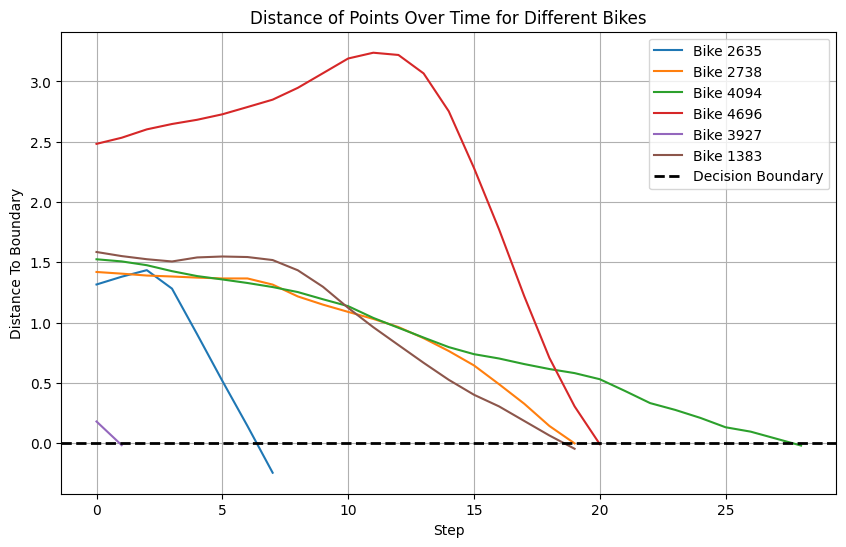

In [8]:
bikes = unusable_bikes_test_df.index

log_usable_scores = []
log_unusable_scores = []

knn_pred = []

all_points = []
bids = []
for bid in bikes:
    bike = unusable_bikes.loc[[bid]]
    latent = tuned_encoder_mean.predict(bike)[0]
    pred_svm = pred_kde = 0
    counter = 0

    bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
    pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
    pred_kde = latent_kde_classifier.predict(latent)[0]

    distances = []

    distances.append(- svm_clf.distance_to_boundary(bike_features_point))

    print('svm:', 'usable' if pred_svm else 'unusable')
    print('kde:', 'usable' if pred_kde else 'unusable')
    while counter < 40 and not (pred_svm == 1):

        counter += 1

        new_point = latent_kde_classifier.move_point(latent,step_scale=0.1, use_direction=4,alpha=0.6)
        latent = new_point

        bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
        pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
        pred_kde = latent_kde_classifier.predict(latent)[0]
        

        distances.append(- svm_clf.distance_to_boundary(bike_features_point))

    if len(distances) > 1:
        bids.append(bid)
        all_points.append(distances)

clear_output(False)

print(f"Number of bikes moved : {len(all_points)}")

time_points = list(range(len(all_points[0])))
plt.figure(figsize=(10, 6))
for i, distances in enumerate(all_points):
    time_points = list(range(len(distances)))
    plt.plot(time_points, distances, label=f'Bike {bids[i]}')  # Using bid labels

# Plot a horizontal line at y=0 (SVM decision boundary)
plt.axhline(0, color='black', linewidth=2, linestyle='--', label='Decision Boundary')  

# Labeling and styling the plot
plt.xlabel('Step')
plt.ylabel('Distance To Boundary')
plt.title('Distance of Points Over Time for Different Bikes')
plt.grid(True)
plt.legend()  # Show legend with bid labels
plt.show()

## Test towards unusable

In [33]:
def initialize_models():
    # best_bandwidth_usable =  0.28
    # best_bandwidth_unusable=  0.25
    
    # Initialize and return fresh instances of the models
    # latent_kde_classifier_temp = LatentKDEClassifier(
    #     best_bandwidth_usable,
    #     best_bandwidth_unusable,
    #     min_confidence_usable=None
    # )
    # latent_kde_classifier_temp.fit(latent_usable_train_filtered, latent_unusable_train_filtered)

    latent_kde_classifier_temp = LatentKDEClassifier(best_bandwidth_usable, best_bandwidth_unusable)
    latent_kde_classifier_temp.fit(latent_usable_train_filtered, latent_unusable_train_filtered)

    tunedVAE = dVAE(ddims, 128, 0.1, 1e-3).build_vae_keras_model_mean()
    tunedVAE.load_weights(f'model weights/{tuned_VAE_name}.h5')
    tuned_encoder_mean = tunedVAE.get_layer('encoder')

    return latent_kde_classifier, tuned_encoder_mean

def process_pair(dir, alpha):
    try:
        # Initialize models locally to avoid pickle issues
        latent_kde_classifier_temp, tuned_encoder_mean = initialize_models()


        bikes = usable_bikes_train_df.index
        pair_results = []
        avg_count = 0
        valid_count = 0

        for bid in bikes:
            bike = usable_bikes.loc[[bid]]
            latent = tuned_encoder_mean.predict(bike)[0]  # Get the latent vector
            points = [latent]
            pred_kde = latent_kde_classifier_temp.predict(latent)[0]
            counter = 0

            while counter < 100 and pred_kde == 1:
                counter += 1
                new_point = latent_kde_classifier_temp.move_point(latent, step_scale=0.1, use_direction=dir, alpha=alpha,  target=False )
                points.append(new_point)
                latent = new_point
                pred_kde = latent_kde_classifier_temp.predict(latent)[0]

            if not pred_kde== 1 and counter > 0:
                avg_count += counter
                valid_count += 1

        pair_results.append({
            'dir': dir,
            'alpha': alpha,
            'avg_count': avg_count / valid_count if valid_count != 0 else np.inf,
            'valid_count': valid_count
        })

        return pair_results

    except Exception as e:
        print(f"Error processing pair (dir={dir}, alpha={alpha}): {e}")
        return [f"Error processing pair (dir={dir}, alpha={alpha}): {e}"]


# Main process
if __name__ == '__main__':
    directions = [i for i in range(1,5)]

    alphas = [0.1,0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9]
    pairs = [(direction, alpha if direction == 4 else None) for direction in directions for alpha in (alphas if direction == 4 else [None])]

    # Parallel execution with separate model initialization for each worker
    results = Parallel(n_jobs=-1)(
        delayed(process_pair)(dir, alpha) for dir, alpha in pairs
    )

    clear_output(False)
    print(results)


[[{'dir': 1, 'alpha': None, 'avg_count': 35.45454545454545, 'valid_count': 11}], [{'dir': 2, 'alpha': None, 'avg_count': 10.972222222222221, 'valid_count': 36}], [{'dir': 3, 'alpha': None, 'avg_count': 11.38888888888889, 'valid_count': 36}], [{'dir': 4, 'alpha': 0.1, 'avg_count': 10.944444444444445, 'valid_count': 36}], [{'dir': 4, 'alpha': 0.2, 'avg_count': 10.916666666666666, 'valid_count': 36}], [{'dir': 4, 'alpha': 0.3, 'avg_count': 11.0, 'valid_count': 36}], [{'dir': 4, 'alpha': 0.4, 'avg_count': 11.11111111111111, 'valid_count': 36}], [{'dir': 4, 'alpha': 0.5, 'avg_count': 11.38888888888889, 'valid_count': 36}], [{'dir': 4, 'alpha': 0.6, 'avg_count': 12.0, 'valid_count': 36}], [{'dir': 4, 'alpha': 0.7, 'avg_count': 13.61111111111111, 'valid_count': 36}], [{'dir': 4, 'alpha': 0.8, 'avg_count': 17.2, 'valid_count': 35}], [{'dir': 4, 'alpha': 0.9, 'avg_count': 26.20689655172414, 'valid_count': 29}]]


Number of bikes moved : 33


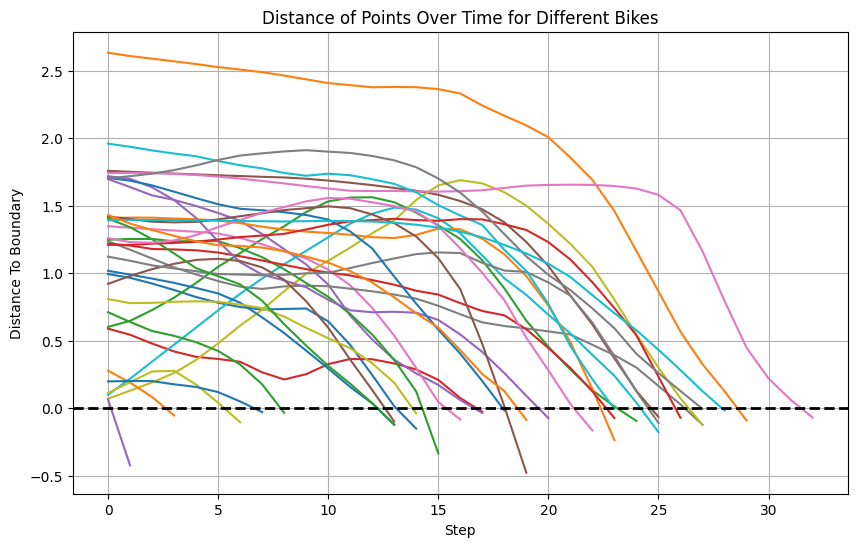

In [10]:
# latent_kde_classifier, tuned_encoder_mean = initialize_models()

bikes = usable_bikes_train_df.index

log_usable_scores = []
log_unusable_scores = []

knn_pred = []

all_points = []

for bid in bikes:
    bike = usable_bikes.loc[[bid]]
    latent = tuned_encoder_mean.predict(bike)[0]
    points = [latent]
    pred_svm = pred_kde = 0
    counter = 0

    bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
    pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
    pred_kde = latent_kde_classifier.predict(latent)[0]

    distances = []

    distances.append( svm_clf.distance_to_boundary(bike_features_point))

    print('svm:', 'usable' if pred_svm else 'unusable')
    print('kde:', 'usable' if pred_kde else 'unusable')
    while counter < 40 and not (pred_svm == 0):

        counter += 1

        new_point = latent_kde_classifier.move_point(latent,step_scale=0.1,use_direction=4,alpha=0.2, target=False)
        points.append(new_point)
        latent = new_point
        
        bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
        pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
        pred_kde = latent_kde_classifier.predict(latent)[0]
        

        distances.append(svm_clf.distance_to_boundary(bike_features_point))

    if len(distances) > 1:
        all_points.append(distances)

clear_output(False)

print(f"Number of bikes moved : {len(all_points)}")

time_points = list(range(len(all_points[0])))
plt.figure(figsize=(10, 6))

for i, distances in enumerate(all_points):
    time_points = list(range(len(distances)))
    plt.plot(time_points, distances, label=f'Bike {i+1}')

plt.axhline(0, color='black', linewidth=2, linestyle='--')  

plt.xlabel('Step')
plt.ylabel('Distance To Boundary')
plt.title('Distance of Points Over Time for Different Bikes')
plt.grid(True)
plt.show()

Number of bikes moved : 10


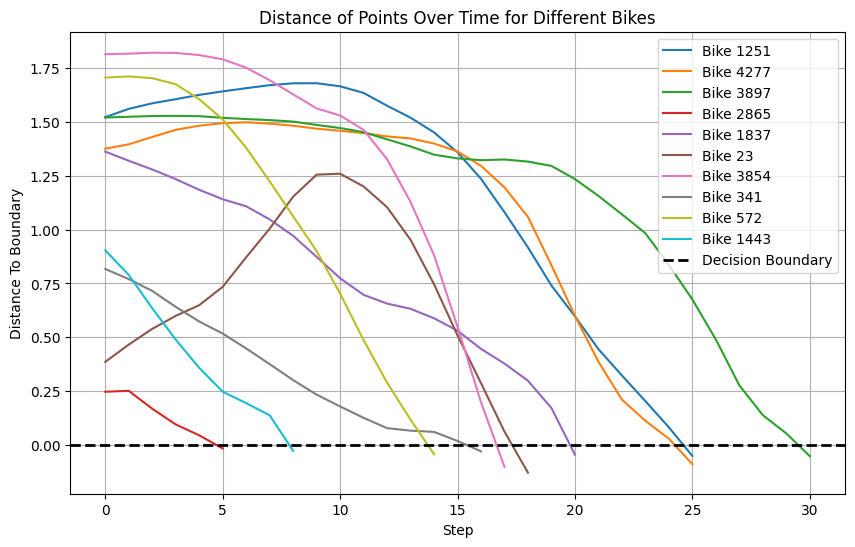

In [11]:
bikes = usable_bikes_test_df.index

log_usable_scores = []
log_unusable_scores = []

knn_pred = []

all_points = []
bids = []
for bid in bikes:
    bike = usable_bikes.loc[[bid]]
    latent = tuned_encoder_mean.predict(bike)[0]
    points = [latent]
    pred_svm = pred_kde = 0
    counter = 0

    bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
    pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
    pred_kde = latent_kde_classifier.predict(latent)[0]

    distances = []

    distances.append( svm_clf.distance_to_boundary(bike_features_point))

    print('svm:', 'usable' if pred_svm else 'unusable')
    print('kde:', 'usable' if pred_kde else 'unusable')
    while counter < 40 and (pred_svm == 1):

        counter += 1

        new_point = latent_kde_classifier.move_point(latent,step_scale=0.1, use_direction=4,alpha= 0.2,  target=False)
        points.append(new_point)
        latent = new_point

        bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
        pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
        pred_kde = latent_kde_classifier.predict(latent)[0]
        

        distances.append( svm_clf.distance_to_boundary(bike_features_point))

    if len(distances) > 1:
        bids.append(bid)
        all_points.append(distances)

clear_output(False)

print(f"Number of bikes moved : {len(all_points)}")

time_points = list(range(len(all_points[0])))
plt.figure(figsize=(10, 6))
for i, distances in enumerate(all_points):
    time_points = list(range(len(distances)))
    plt.plot(time_points, distances, label=f'Bike {bids[i]}')  # Using bid labels

# Plot a horizontal line at y=0 (SVM decision boundary)
plt.axhline(0, color='black', linewidth=2, linestyle='--', label='Decision Boundary')  

# Labeling and styling the plot
plt.xlabel('Step')
plt.ylabel('Distance To Boundary')
plt.title('Distance of Points Over Time for Different Bikes')
plt.grid(True)
plt.legend()  # Show legend with bid labels
plt.show()

## Visualization of Guiding Unusable Designs Towards Usable Regions in the Latent Space

In [7]:

def visualise_guided_bike(kde_clf, bike):
    latent = tuned_encoder_mean.predict(bike)[0]
    points = [latent]
    pred_smv = pred_kde = 0
    counter = 0

    bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
    pred_smv = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
    pred_kde = kde_clf.predict(latent)[0]

    print(svm_clf.distance_to_boundary(bike_features_point))

    print('svm:', 'usable' if pred_smv else 'unusable')
    print('kde:', 'usable' if pred_kde else 'unusable')

    while counter < 100 and not (pred_smv == pred_kde == 1):
        counter += 1

        print(f"\n########## Start {counter} ##########")

        new_point = kde_clf.move_point(latent,step_scale=0.1, use_direction= 4, alpha = 0.6)
        points.append(new_point)
        latent = new_point
        
        bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
        pred_smv = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
        pred_kde = kde_clf.predict(latent)[0]
        
        print(svm_clf.distance_to_boundary(bike_features_point))


        print('svm:', 'usable' if pred_smv else 'unusable')
        print('kde:', 'usable' if pred_kde else 'unusable')

        print("########## End ############\n")


        
    points_tensor = tf.convert_to_tensor(points)
    res = (tf.math.sigmoid(tuned_decoder.predict(points_tensor))).numpy()
    indices = [f'{bike.index[0]}_moved_{i}' for i in range(len(points))]
    temp = pd.DataFrame(res, index=indices, columns=dfn.columns)
    temp.to_csv(f"../data/regen.csv")
    processGen.processGen("regen", denorm=True)

In [33]:
unusable_bikes_test_dfn.index.tolist()


[1246, 1771, 2635, 2087, 2738, 4094, 4696, 3927, 1383, 3012]

In [9]:
def visualise_guided_bike(kde_clf, bike):
    latent = tuned_encoder_mean.predict(bike)[0]
    points = [latent]
    pred_smv = pred_kde = 0
    counter = 0

    bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
    pred_smv = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
    pred_kde = kde_clf.predict(latent)[0]

    print(svm_clf.distance_to_boundary(bike_features_point))

    print('svm:', 'usable' if pred_smv else 'unusable')
    print('kde:', 'usable' if pred_kde else 'unusable')

    while counter < 40 :
        counter += 1

        print(f"\n########## Start {counter} ##########")

        new_point = kde_clf.move_point(latent,step_scale=0.1, use_direction= 4, alpha = 0.6)
        points.append(new_point)
        latent = new_point
        
        bike_features_point = (tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy())[0][column_indices_to_keep]
        pred_smv = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
        pred_kde = kde_clf.predict(latent)[0]
        
        print(svm_clf.distance_to_boundary(bike_features_point))


        print('svm:', 'usable' if pred_smv else 'unusable')
        print('kde:', 'usable' if pred_kde else 'unusable')

        print("########## End ############\n")


        
    points_tensor = tf.convert_to_tensor(points)
    res = (tf.math.sigmoid(tuned_decoder.predict(points_tensor))).numpy()
    indices = [f'{bike.index[0]}_moved_{i}' for i in range(len(points))]
    temp = pd.DataFrame(res, index=indices, columns=dfn.columns)
    temp.to_csv(f"../data/regen.csv")
    processGen.processGen("regen", denorm=True)

In [11]:
# bike = unusable_bikes.loc[[2635]]
bike = unusable_bikes.loc[[4094]]

visualise_guided_bike(latent_kde_classifier, bike)

1/1 [==============================] - 0s 25ms/step
[-1.52557994]
svm: unusable
kde: unusable

########## Start 1 ##########
log_likelihood_usable=[-12.70227609]  log_likelihood_unusable= [24.26780153]
1/1 [==============================] - 0s 18ms/step
[-1.50784155]
svm: unusable
kde: unusable
########## End ############


########## Start 2 ##########
log_likelihood_usable=[-9.74342993]  log_likelihood_unusable= [22.86027611]
1/1 [==============================] - 0s 18ms/step
[-1.47632141]
svm: unusable
kde: unusable
########## End ############


########## Start 3 ##########
log_likelihood_usable=[-6.84924922]  log_likelihood_unusable= [21.3843088]
1/1 [==============================] - 0s 18ms/step
[-1.42704222]
svm: unusable
kde: unusable
########## End ############


########## Start 4 ##########
log_likelihood_usable=[-4.02223026]  log_likelihood_unusable= [19.82490373]
1/1 [==============================] - 0s 19ms/step
[-1.38613366]
svm: unusable
kde: unusable
########## End 

c:\Users\fabie\Desktop\Thesis1\My_ratings\Main\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\Main\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\Main\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

One-hot encoding 106 features
Onehot Completed in 0.40400195121765137 seconds
Loaded Imputed Dataframe in  1.5000100135803223 seconds


c:\Users\fabie\Desktop\Thesis1\My_ratings\Main\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\Main\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\Main\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

## Minimum Confidence Threshold for the Usable Log-likelihood

### How does min confidence affect distances to regenerated bikes

In [26]:
# Define thresholds based on mean and standard deviation of usable log-likelihood scores
# mean_usable = np.mean(log_usable_scores)
# std_usable = np.std(log_usable_scores)
thresholds = [
    None,
    # -20,
    -10,
    0,
    10,
    20,
    30,
    40
]

# Initialize strict KDE classifiers for each threshold
kdes = []
for threshold in thresholds:
    latent_kde_classifier_strict = LatentKDEClassifier(best_bandwidth_usable, best_bandwidth_unusable, threshold)
    latent_kde_classifier_strict.fit(latent_usable_train_filtered, latent_unusable_train_filtered)
    kdes.append(latent_kde_classifier_strict)

svm_bikes = []
kde_strict_bikes = [[] for _ in thresholds]  # Separate list for each threshold
kde_strict_sign = [[] for _ in thresholds]  # Separate list for each threshold

all_bids = []
# Loop through each bike in the test set
for bid in unusable_bikes_test_dfn.index:  
    bike = unusable_bikes_test_dfn.loc[[bid]]
    latent = tuned_encoder_mean.predict(bike)[0]
    points = [latent]

    # Predict initial classification with base classifiers
    bike_parameters = tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy()
    bike_features_point = bike_parameters[0][column_indices_to_keep]
    
    # Predict with SVM and base KDE
    # pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
    preds_strict = [0 for _ in range(len(kdes))]  # Start with 0 (no classification)
    pred_svm = 0
    # Track if the bike has been added to each list
    counter = 0
    svm_count = float('inf')  # Track when SVM was first classified



    bike_features_point = bike_parameters[0][column_indices_to_keep]
    pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
    if pred_svm == 1:
        svm_bikes.append(bike_parameters[0])  # Add as a new row
        svm_count = counter  # Track when SVM first made its decision

    # Update each threshold-specific classifier prediction and append results if not already added
    for i, latent_kde_classifier_strict in enumerate(kdes):
        if preds_strict[i] == 0 :
            preds_strict[i] = latent_kde_classifier_strict.predict(latent)[0]
            if preds_strict[i] == 1:
                kde_strict_bikes[i].append(bike_parameters[0])  # Add as a new row
                # Track the sign based on the counter
                if counter > svm_count:
                    kde_strict_sign[i].append(1)  # Positive sign
                else:
                    kde_strict_sign[i].append(-1)  # Negative sign

    max_counter = 50
    # If the bike is not classified by SVM or KDE yet, keep iterating
    while counter < max_counter and not (pred_svm == 1 and all(pred == 1 for pred in preds_strict)):

        counter += 1

        print(f"\n########## Step {counter} ########## Bike ID: {bid} ##########")

        # Move point closer to the decision boundary
        new_point = latent_kde_classifier_strict.move_point(latent, step_scale=0.1, use_direction=4, alpha= 0.6)
        latent = new_point
        points.append(latent)

        # Predict updated classifications
        bike_parameters = tf.math.sigmoid(tuned_decoder.predict(np.array([latent]))).numpy()

        
            # Append results for SVM and KDE if not yet added
        if  pred_svm == 0 :
            bike_features_point = bike_parameters[0][column_indices_to_keep]
            pred_svm = svm_clf.predict(bike_features_point.reshape(1, -1))[0]
            if pred_svm == 1:
                svm_bikes.append(bike_parameters[0])  # Add as a new row
                svm_count = counter  # Track when SVM first made its decision

        # Update each threshold-specific classifier prediction and append results if not already added
        for i, latent_kde_classifier_strict in enumerate(kdes):
            if preds_strict[i] == 0 :
                preds_strict[i] = latent_kde_classifier_strict.predict(latent)[0]
                if preds_strict[i] == 1:
                    kde_strict_bikes[i].append(bike_parameters[0])  # Add as a new row
                    # Track the sign based on the counter
                    if counter > svm_count:
                        kde_strict_sign[i].append(1)  # Positive sign
                    else:
                        kde_strict_sign[i].append(-1)  # Negative sign

    if counter == max_counter:
        for i, latent_kde_classifier_strict in enumerate(kdes):
            if preds_strict[i] == 0 :
                kde_strict_bikes[i].append(bike_parameters[0])  # Add as a new row
                # Track the sign based on the counter
                if counter > svm_count:
                    kde_strict_sign[i].append(1)  # Positive sign
                else:
                    kde_strict_sign[i].append(-1)  # Negative sign

                    
        print("########## End of Step ##########\n")

clear_output(False)

Average distance for threshold None: 2.0727
Average distance for threshold -10: 2.0727
Average distance for threshold 0: 2.0727
Average distance for threshold 10: 2.1497
Average distance for threshold 20: 2.8263
Average distance for threshold 30: 3.4332
Average distance for threshold 40: 4.9689


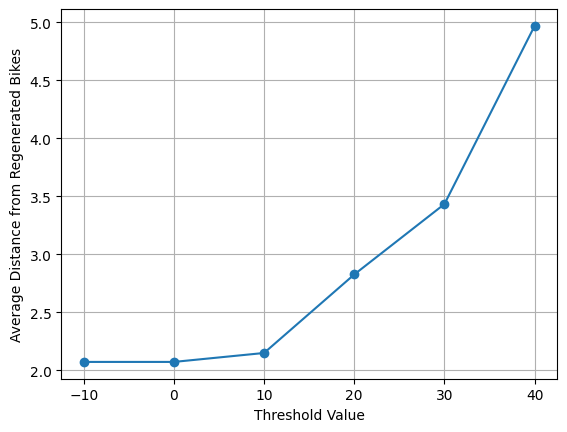

In [29]:


# Function to compute Euclidean distance between two points
def compute_avg_distance(list1, list2, sign):
    # Flatten each bike's parameters to ensure they are 1-D arrays and multiply by the sign
    return np.mean([euclidean(bike1.flatten(), bike2.flatten()) 
                    for i, (bike1, bike2) in enumerate(zip(list1, list2))])
# Initialize a list to store average distances for each threshold
avg_distances_per_threshold = []

# Loop through each threshold in kde_strict_bikes
for i, threshold_bikes in enumerate(kde_strict_bikes):
    # If there are any bikes in both svm_bikes and kde_strict_bikes for this threshold
    if svm_bikes and threshold_bikes:
        # Compute the average distance between SVM bikes and the bikes for this threshold
        avg_distance = compute_avg_distance(svm_bikes, threshold_bikes, kde_strict_sign[i]) 
        avg_distances_per_threshold.append(avg_distance)
    else:
        avg_distances_per_threshold.append(np.nan)  # If no bikes for this threshold, append NaN

# Print the results for each threshold
for i, avg_dist in enumerate(avg_distances_per_threshold):
    print(f"Average distance for threshold {thresholds[i]}: {avg_dist:.4f}")

# Optionally, if you want to plot the results
import matplotlib.pyplot as plt

plt.plot(thresholds[1:], avg_distances_per_threshold[1:], marker='o')


# # Add labels to each dot
# for i, threshold in enumerate(thresholds[1:]):
#     plt.text(threshold, avg_distances_per_threshold[i], str(threshold), ha='center', va='bottom', fontsize=9)

# plt.axhline(0, color='k', linestyle='--')

# Labels and title
plt.xlabel('Threshold Value')
# plt.ylabel('Average Distance from SVM Bikes')
plt.ylabel('Average Distance from Regenerated Bikes')

# plt.title('Average Euclidean Distances for Different Thresholds')
plt.grid(True)
plt.show()

### How does min confidence affect distances to SVM bikes


Average distance for threshold None: -0.8360
Average distance for threshold -10: -0.8360
Average distance for threshold 0: -0.8360
Average distance for threshold 10: -0.3881
Average distance for threshold 20: 0.4985
Average distance for threshold 30: 2.3601
Average distance for threshold 40: 4.9689


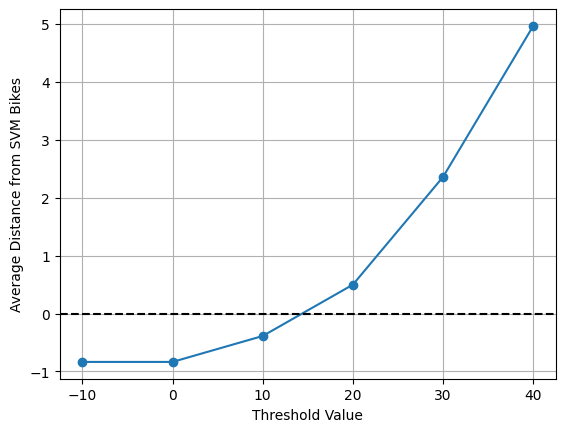

In [30]:

# Function to compute Euclidean distance between two points
def compute_avg_distance(list1, list2, sign):
    # Flatten each bike's parameters to ensure they are 1-D arrays and multiply by the sign
    return np.mean([sign[i] * euclidean(bike1.flatten(), bike2.flatten()) 
                    for i, (bike1, bike2) in enumerate(zip(list1, list2))])
# Initialize a list to store average distances for each threshold
avg_distances_per_threshold = []

# Loop through each threshold in kde_strict_bikes
for i, threshold_bikes in enumerate(kde_strict_bikes):
    # If there are any bikes in both svm_bikes and kde_strict_bikes for this threshold
    if svm_bikes and threshold_bikes:
        # Compute the average distance between SVM bikes and the bikes for this threshold
        avg_distance = compute_avg_distance(svm_bikes, threshold_bikes, kde_strict_sign[i]) 
        avg_distances_per_threshold.append(avg_distance)
    else:
        avg_distances_per_threshold.append(np.nan)  # If no bikes for this threshold, append NaN

# Print the results for each threshold
for i, avg_dist in enumerate(avg_distances_per_threshold):
    print(f"Average distance for threshold {thresholds[i]}: {avg_dist:.4f}")

# Optionally, if you want to plot the results
import matplotlib.pyplot as plt

plt.plot(thresholds[1:], avg_distances_per_threshold[1:], marker='o')


# # Add labels to each dot
# for i, threshold in enumerate(thresholds[1:]):
#     plt.text(threshold, avg_distances_per_threshold[i], str(threshold), ha='center', va='bottom', fontsize=9)

plt.axhline(0, color='k', linestyle='--')

# Labels and title
plt.xlabel('Threshold Value')
plt.ylabel('Average Distance from SVM Bikes')
# plt.ylabel('Average Distance from Regenerated Bikes')

# plt.title('Average Euclidean Distances for Different Thresholds')
plt.grid(True)
plt.show()

In [34]:
unusable_bikes_test_dfn.index.tolist()


[1246, 1771, 2635, 2087, 2738, 4094, 4696, 3927, 1383, 3012]

In [42]:
latent_kde_classifier_strict = LatentKDEClassifier(best_bandwidth_usable, best_bandwidth_unusable, 20)
latent_kde_classifier_strict.fit(latent_usable_train_filtered, latent_unusable_train_filtered)
bike = unusable_bikes.loc[[2635]]
visualise_guided_bike(latent_kde_classifier_strict, bike)

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 24ms/step
[-1.31644231]
svm: unusable
kde: unusable

########## Start 1 ##########
log_likelihood_usable=[-16.50017719]  log_likelihood_unusable= [13.87945568]
1/1 [==============================] - 0s 23ms/step
[-1.38082442]
svm: unusable
kde: unusable
########## End ############


########## Start 2 ##########
log_likelihood_usable=[-13.41720376]  log_likelihood_unusable= [12.10835627]
1/1 [==============================] - 0s 18ms/step
[-1.43540052]
svm: unusable
kde: unusable
########## End ############


########## Start 3 ##########
log_likelihood_usable=[-10.42608991]  log_likelihood_unusable= [10.38574392]
1/1 [==============================] - 0s 20ms/step
[-1.28209983]
svm: unusable
kde: unusable
########## End ############


########## Start 4 ##########
log_likelihood_usable=[-7.52831724]  log_likelihood_unusable= [8.9175262]
1/1 [==============================] - 0s 20ms/step
[-0.90336674]
svm: unusable
kde: unusable
########## End

c:\Users\fabie\Desktop\Thesis1\My_ratings\Main\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\Main\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf.at[:,column]=df[column]
c:\Users\fabie\Desktop\Thesis1\My_ratings\Main\Functions\dataFrameTools.py:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

One-hot encoding 106 features
Onehot Completed in 0.6280384063720703 seconds
Loaded Imputed Dataframe in  1.496023178100586 seconds


c:\Users\fabie\Desktop\Thesis1\My_ratings\Main\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\Main\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col]=[0]*len(df.index)
c:\Users\fabie\Desktop\Thesis1\My_ratings\Main\Functions\dataFrameTools.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid